# GPU Regressions
by Martin Popovski

Data: https://www.kaggle.com/iliassekkaf/computerparts?select=All_GPUs.csv

## Data cleaning

In [1]:
import pandas as pd
import math
import re

In [2]:
df1 = pd.read_csv('data/All_GPUs.csv')

In [3]:
df1

,Architecture,Best_Resolution,Boost_Clock,Core_Speed,DVI_Connection,Dedicated,Direct_X,DisplayPort_Connection,HDMI_Connection,Integrated,...,Process,ROPs,Release_Date,Release_Price,Resolution_WxH,SLI_Crossfire,Shader,TMUs,Texture_Rate,VGA_Connection
0,Tesla G92b,NaN,NaN,738 MHz,2.0,Yes,DX 10.0,NaN,0.0,No,...,55nm,16,\n01-Mar-2009,NaN,2560x1600,Yes,4.0,64.0,47 GTexel/s,0.0
1,R600 XT,1366 x 768,NaN,\n-,2.0,Yes,DX 10,NaN,0.0,No,...,80nm,16,\n14-May-2007,NaN,2560x1600,Yes,4.0,16.0,12 GTexel/s,0.0
2,R600 PRO,1366 x 768,NaN,\n-,2.0,Yes,DX 10,NaN,0.0,No,...,80nm,16,\n07-Dec-2007,NaN,2560x1600,Yes,4.0,16.0,10 GTexel/s,0.0
3,RV630,1024 x 768,NaN,\n-,2.0,Yes,DX 10,NaN,0.0,No,...,65nm,4,\n01-Jul-2007,NaN,2560x1600,Yes,4.0,8.0,7 GTexel/s,0.0
4,RV630,1024 x 768,NaN,\n-,2.0,Yes,DX 10,NaN,0.0,No,...,65nm,4,\n28-Jun-2007,NaN,2560x1600,Yes,4.0,8.0,6 GTexel/s,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3401,MCP61,NaN,NaN,\n-,1.0,No,DX 9.0c,NaN,1.0,Yes,...,NaN,NaN,\n01-Jun-2006,NaN,2560x1600,No,3.0,NaN,NaN,1.0
3402,MCP61,NaN,NaN,\n-,0.0,No,DX 9.0c,NaN,0.0,Yes,...,NaN,NaN,\n01-Jun-2006,NaN,2560x1600,No,3.0,NaN,NaN,1.0
3403,MCP51,NaN,NaN,\n-,0.0,NaN,DX 9,NaN,0.0,NaN,...,NaN,NaN,\n20-Oct-2005,NaN,NaN,No,NaN,NaN,NaN,0.0
3404,MCP51,NaN,NaN,\n-,NaN,No,DX 9.0c,NaN,0.0,Yes,...,NaN,NaN,\n01-Nov-2005,NaN,2560x1600,No,3.0,NaN,NaN,1.0


First we only take the GPUs with non null Release_Price, this reduces our row count from 3406 to 556.  

In [4]:
df2 = df1[df1['Release_Price'].notnull()].copy().reset_index(drop=True)

Most regression columns are in string form, so let's format them and convert all of them into float type.

In [5]:
def string_to_float(x):
    if isinstance(x, float) and math.isnan(x):
        return None
    try:
        return float(re.sub(r'[^0-9.]', '', x))
    except ValueError:
        return None

df2['Release_Price'] = df2['Release_Price'].apply(string_to_float)
df2['Boost_Clock'] = df2['Boost_Clock'].apply(string_to_float)
df2['Core_Speed'] = df2['Core_Speed'].apply(string_to_float)
df2['Texture_Rate'] = df2['Texture_Rate'].apply(string_to_float)
df2['Pixel_Rate'] = df2['Pixel_Rate'].apply(string_to_float)

Extract release year from Release_Date

In [6]:
def release_date_to_year(x):
    match = re.search(r'\d+\-\w+\-(\d{4})', x)
    if match:
        return match.group(1)
    else:
        return None

df2['Release_Year'] = df2['Release_Date'].apply(release_date_to_year)

In [7]:
df2

,Architecture,Best_Resolution,Boost_Clock,Core_Speed,DVI_Connection,Dedicated,Direct_X,DisplayPort_Connection,HDMI_Connection,Integrated,...,ROPs,Release_Date,Release_Price,Resolution_WxH,SLI_Crossfire,Shader,TMUs,Texture_Rate,VGA_Connection,Release_Year
0,Pascal GP102,3840 x 2160,1531.0,NaN,1.0,NaN,DX 12,3.0,1.0,NaN,...,96,\n02-Aug-2016,1199.0,7680x4320,No,5.0,224.0,343.0,0.0,2016
1,Pascal GP102,3840 x 2160,1582.0,NaN,1.0,Yes,DX 12,3.0,1.0,No,...,24 (x4),\n06-Apr-2017,1199.0,7680x4320,Yes,5.0,56.0,354.0,0.0,2017
2,Kepler GK110-430-B1 (x2),5760 x 1600,876.0,705.0,2.0,Yes,DX 12.0,NaN,1.0,No,...,48 (x2),\n28-May-2014,2999.0,4096x2160,Yes,5.0,240.0,420.0,0.0,2014
3,Kepler GK110-430-B1 (x2),3840 x 2160,876.0,705.0,2.0,Yes,DX 12.0,NaN,1.0,No,...,48 (x2),\n28-May-2014,2999.0,4096x2160,Yes,5.0,240.0,420.0,0.0,2014
4,Maxwell GM200-400-A1,3840 x 2160,1252.0,1140.0,1.0,Yes,DX 12.1,NaN,1.0,No,...,96,\n17-Mar-2015,1099.0,4096x2160,Yes,5.0,192.0,240.0,0.0,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551,Kepler GK107-425-A2,1600 x 900,NaN,993.0,2.0,Yes,DX 12.0,NaN,0.0,No,...,16,\n29-May-2014,89.0,4096x2160,No,5.0,32.0,32.0,0.0,2014
552,Kepler GK107-425-A2,1366 x 768,NaN,993.0,2.0,Yes,DX 12.0,NaN,0.0,No,...,16,\n 29-May-2014,79.0,4096x2160,No,5.0,32.0,32.0,0.0,2014
553,Kepler GK208,1366 x 768,NaN,797.0,1.0,Yes,DX 12.0,NaN,1.0,No,...,8,\n27-Mar-2014,59.0,4096x2160,No,5.0,16.0,13.0,1.0,2014
554,Kepler GK208,1366 x 768,NaN,902.0,1.0,Yes,DX 12.0,NaN,1.0,No,...,8,\n18-Jun-2014,89.0,4096x2160,No,5.0,16.0,14.0,1.0,2014


In [8]:
df2.to_csv('data/All_GPUs_clean.csv', index=False)

## Definitions

In order to better understand the data, let's take a look at the definitions of some of the attributes in this data.

The term pixel fillrate refers to the number of pixels a video card can render to screen and write to video memory in a second or in case of texture fillrate the number of texture map elements (texels) GPU can map to pixels in a second. Pixel fillrates are given in megapixels per second or in gigapixels per second (in the case of newer cards), and they are obtained by multiplying the number of Raster Output Units (ROPs) by the clock frequency of the graphics processor unit (GPU) of a video card and texture fillrate is obtained by multiplying the number of Texture Mapping Units (TMUs) by the clock frequency of the graphics processing unit (GPU). Texture fillrates are given in mega or gigatexels per second. However, there is no full agreement on how to calculate and report fillrates.

Source: https://en.wikipedia.org/wiki/Fillrate

## Visualization

### Pair plots and heat maps

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
df2 = pd.read_csv('data/All_GPUs_clean.csv')

In [11]:
regression_columns = ['Boost_Clock', 'Core_Speed', 'Pixel_Rate', 'Release_Price', 'TMUs', 'Texture_Rate']

In [12]:
df2[regression_columns].describe()

,Boost_Clock,Core_Speed,Pixel_Rate,Release_Price,TMUs,Texture_Rate
count,404.000000,477.000000,556.000000,556.000000,556.000000,556.000000
mean,1358.722772,1102.014675,54.958633,371.562446,96.050360,141.856115
std,247.675621,259.130077,39.649411,698.262897,53.689508,93.223093
min,780.000000,550.000000,3.000000,23.000000,8.000000,5.000000
25%,1216.000000,926.000000,26.000000,159.750000,60.000000,68.000000
50%,1295.000000,1090.000000,43.000000,240.000000,72.000000,128.000000
75%,1480.000000,1190.000000,82.000000,421.500000,128.000000,193.250000
max,1936.000000,1784.000000,233.000000,14999.000000,384.000000,555.000000


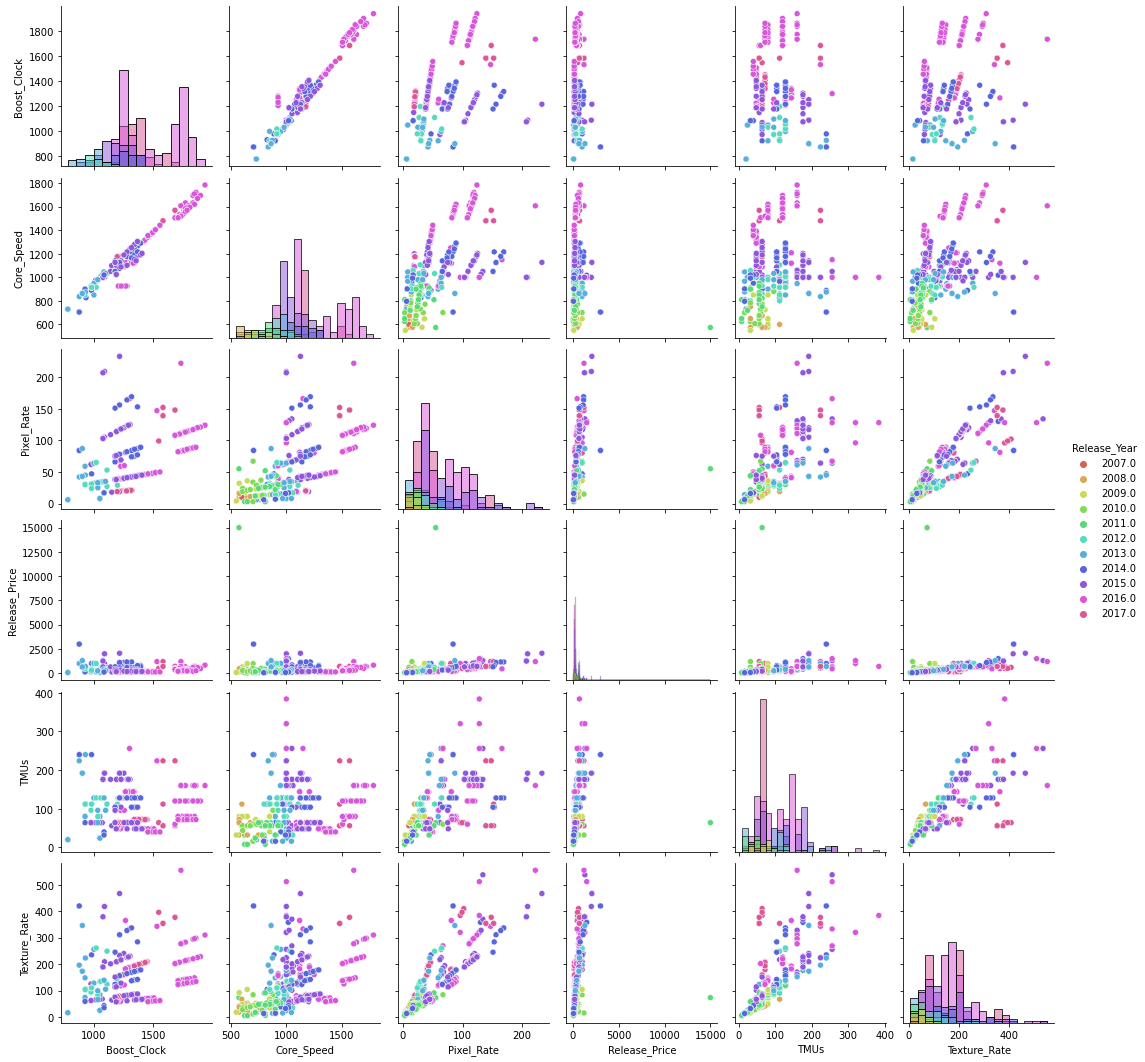

In [41]:
sns.pairplot(df2[regression_columns + ['Release_Year']], hue='Release_Year', diag_kind="hist", palette=sns.color_palette('hls', 11))

We can notice that for Release_Price there are some outliers in the data that are skewing the scatterplots. Let's remove these outliers.

In [14]:
release_price = df2['Release_Price']

In [15]:
release_price.describe()

count      556.000000
mean       371.562446
std        698.262897
min         23.000000
25%        159.750000
50%        240.000000
75%        421.500000
max      14999.000000
Name: Release_Price, dtype: float64

<AxesSubplot:xlabel='Release_Price'>

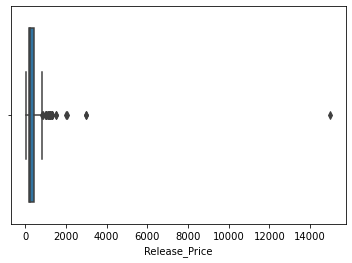

In [16]:
sns.boxplot(x=release_price)

We take the release prices in the range of 5% quantile and 95% quantile.

In [17]:
release_price_adjusted_mask = release_price.between(release_price.quantile(0.05), release_price.quantile(0.95))

In [18]:
df3 = df2[release_price_adjusted_mask].copy().reset_index(drop=True)

In [19]:
df3['Release_Price'].describe()

count    509.000000
mean     312.272652
std      201.803485
min       99.000000
25%      174.000000
50%      240.000000
75%      398.000000
max      999.000000
Name: Release_Price, dtype: float64

<AxesSubplot:xlabel='Release_Price'>

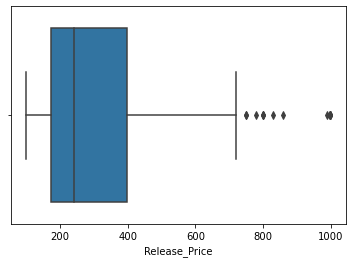

In [40]:
sns.boxplot(x=df3['Release_Price'])

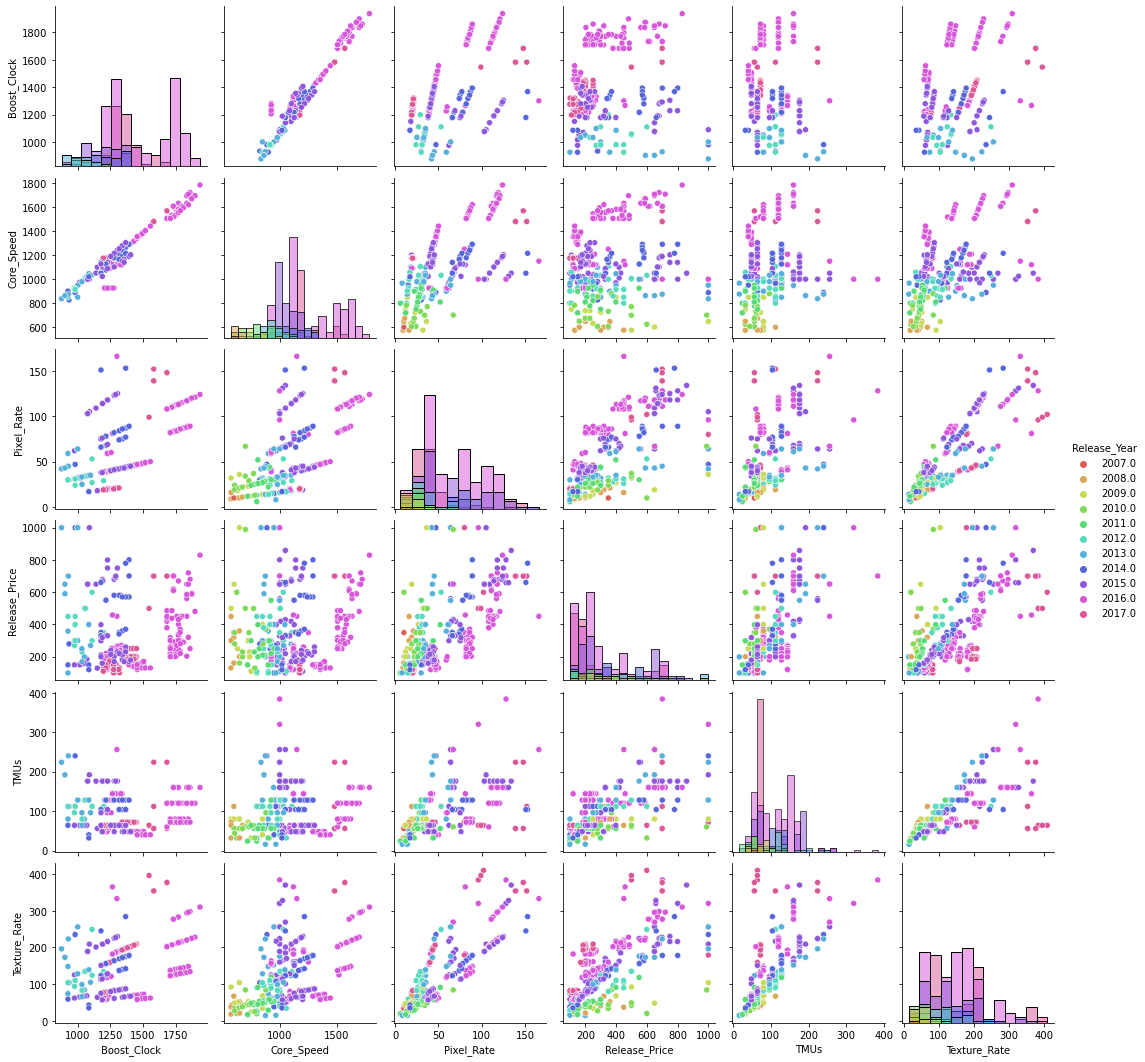

In [21]:
sns.pairplot(df3[regression_columns + ['Release_Year']], hue='Release_Year', diag_kind="hist", palette=sns.color_palette('hls', 11))

We now have a better visualization of Release_Price

<AxesSubplot:>

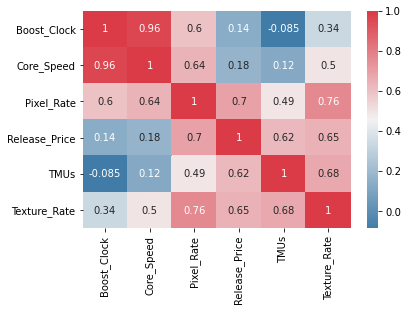

In [22]:
corr = df3[regression_columns].corr()
sns.heatmap(corr, annot=True, cmap=sns.diverging_palette(240, 10, as_cmap = True))

Since Release_Price stays the same for yearly releases of GPUs but the performance get's better by year as GPUs improve, let's see the pairplot and heatmap for a single year.

<AxesSubplot:>

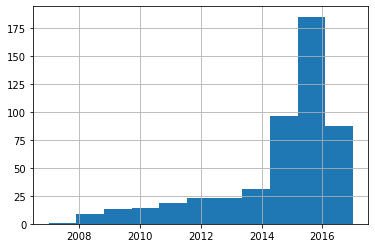

In [23]:
df3['Release_Year'].hist(bins=11)

In [24]:
df3['Release_Year'].value_counts()

2016.0    185
2015.0     96
2017.0     87
2014.0     31
2013.0     23
2012.0     23
2011.0     19
2010.0     14
2009.0     13
2008.0      9
2007.0      1
Name: Release_Year, dtype: int64

We will choose 2016 since it has the largest number of releases.

In [25]:
df4 = df3[df3['Release_Year'] == 2016].copy().reset_index(drop=True)

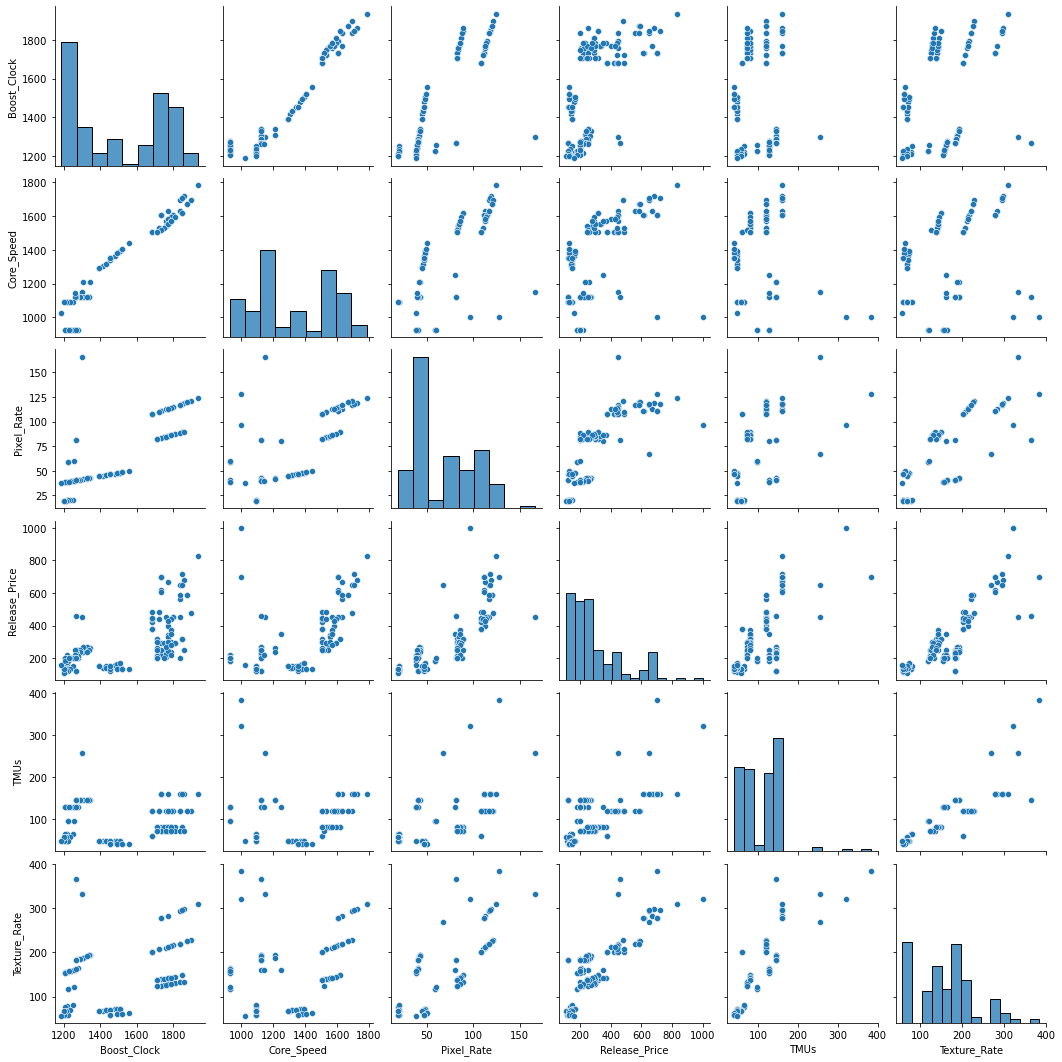

In [26]:
sns.pairplot(df4[regression_columns], diag_kind="hist")

<AxesSubplot:>

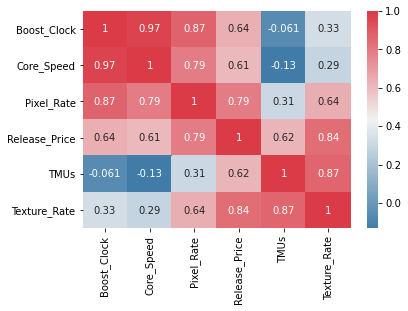

In [27]:
corr = df4[regression_columns].corr()
sns.heatmap(corr, annot=True, cmap=sns.diverging_palette(240, 10, as_cmap = True))

Correlation between the variables has significantly increased now that we limited the Release_Year.

### Linear regression

In [28]:
from sklearn.linear_model import LinearRegression

In [44]:
def get_linear_regression_stats_df(x, y, data):
    model = LinearRegression().fit(data[[x]], data[y])
    model_stats_df = pd.DataFrame()
    r_sq = model.score(data[[x]], data[y])
    model_stats_df['Coefficient of determination'] = [r_sq]
    model_stats_df['Intercept'] = [model.intercept_]
    model_stats_df['Slope'] = [model.coef_]
    model_stats_df['x'] = [x]
    model_stats_df['y'] = [y]
    return model_stats_df 

#### All years

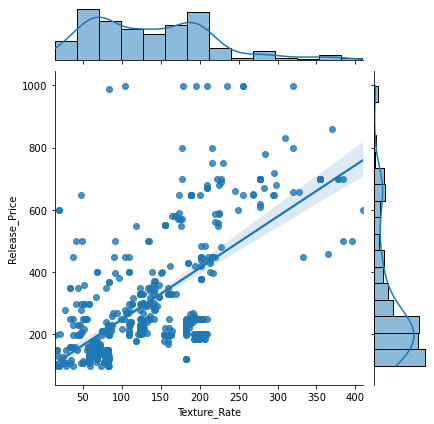

In [30]:
sns.jointplot(x='Texture_Rate', y='Release_Price', data=df3, kind='reg')

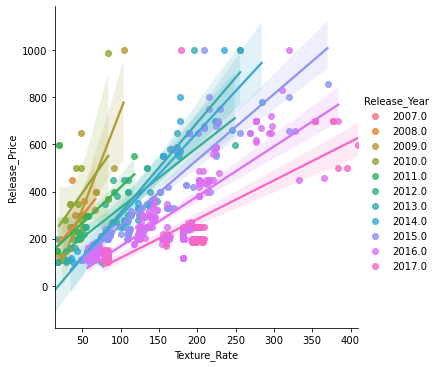

In [31]:
sns.lmplot(x='Texture_Rate', y='Release_Price', data=df3, hue='Release_Year')

We can notice a pattern in the plot, that the more recent the year, the lower the linear regression line is. This means that as GPUs advance we get higher texture rates for lower release prices.

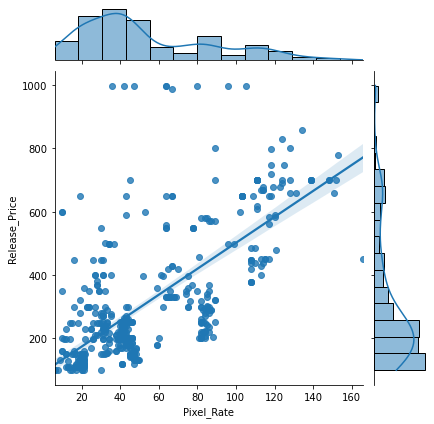

In [32]:
sns.jointplot(x='Pixel_Rate', y='Release_Price', data=df3, kind='reg')

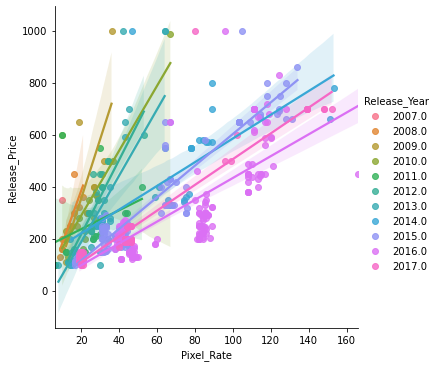

In [33]:
sns.lmplot(x='Pixel_Rate', y='Release_Price', data=df3, hue='Release_Year')

#### 2016

##### x=Texture_Rate, y=Release_Price

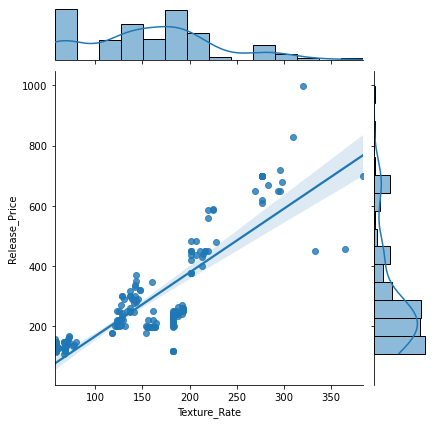

In [34]:
sns.jointplot(x='Texture_Rate', y='Release_Price', data=df4, kind='reg')

<AxesSubplot:xlabel='Texture_Rate', ylabel='Release_Price'>

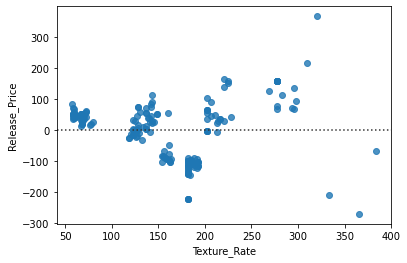

In [35]:
sns.residplot(x='Texture_Rate', y='Release_Price', data=df4)

In [56]:
stats_df = get_linear_regression_stats_df(x='Texture_Rate', y='Release_Price', data=df4)
stats_df

,Coefficient of determination,Intercept,Slope,x,y
0,0.708038,-43.799351,[2.1151808722573087],Texture_Rate,Release_Price


##### x=Pixel_Rate, y=Release_Price

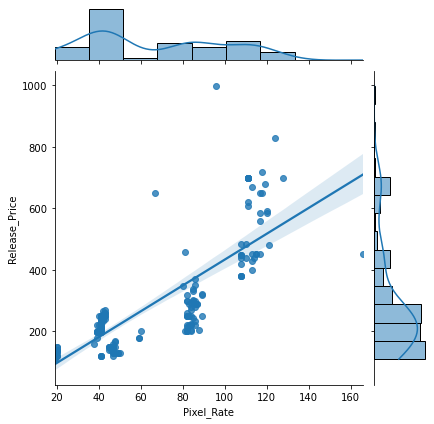

In [37]:
sns.jointplot(x='Pixel_Rate', y='Release_Price', data=df4, kind='reg')

<AxesSubplot:xlabel='Pixel_Rate', ylabel='Release_Price'>

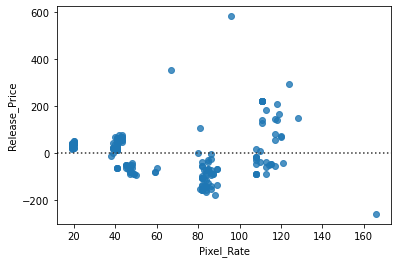

In [38]:
sns.residplot(x='Pixel_Rate', y='Release_Price', data=df4)

In [57]:
stats_df_tmp = get_linear_regression_stats_df(x='Pixel_Rate', y='Release_Price', data=df4)
stats_df = pd.concat([stats_df, stats_df_tmp])
stats_df

,Coefficient of determination,Intercept,Slope,x,y
0,0.708038,-43.799351,[2.1151808722573087],Texture_Rate,Release_Price
0,0.628842,13.329310,[4.198893538204018],Pixel_Rate,Release_Price
